In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [9]:
nx = 100    
ny = 50
nu = np.float128(0.01)
lx = np.float128(1.0)
ly = np.float128(0.5)
dx = np.float128(lx/nx)
dy = np.float128(ly/ny)
dt = np.float128(0.0025)


#Reynolds number is inversely proportional to nu


In [10]:
#sparse solver from prof Saad lecture on iterative solvers. 
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
# build pressure coefficient matrix
Ap = np.zeros([ny,nx])
Ae = 1.0/dx/dx*np.ones([ny,nx])
As = 1.0/dy/dy*np.ones([ny,nx])
An = 1.0/dy/dy*np.ones([ny,nx])
Aw = 1.0/dx/dx*np.ones([ny,nx])
# set left wall coefs
Aw[:,0] = 0.0

# set right wall coefs
Ae[:,-1] = 0.0

# set top wall coefs
An[-1,:] = 0.0
# set bottom wall coefs
As[0,:] = 0.0
Ap = -(Aw + Ae + An + As)

n = nx*ny
d0 = Ap.reshape(n)
# print(d0)
de = Ae.reshape(n)[:-1]
# print(de)
dw = Aw.reshape(n)[1:]
# print(dw)
ds = As.reshape(n)[nx:]
# print(ds)
dn = An.reshape(n)[:-nx]
# print(dn)
A1 = scipy.sparse.diags([d0, de, dw, dn, ds], [0, 1, -1, nx, -nx], format='csr')


In [11]:
#Initializing vector fields plus pressure. 1 ghost cell surrounding therefore n+2 grid. 

u = np.zeros([ny+2, nx+2],dtype=np.float128)
v = np.zeros([ny+2, nx+2],dtype=np.float128)
p = np.zeros([ny+2, nx+2],dtype=np.float128)

ut = np.zeros([ny+2, nx+2],dtype=np.float128)
vt = np.zeros([ny+2, nx+2],dtype=np.float128)



prhs = np.zeros_like(p)



frames = 50 #number of time iterations 

#blank arrays holding values of all the interations 
u_frames = np.zeros([ny+2,nx+2,frames],dtype=np.float128)
v_frames = np.zeros([ny+2,nx+2,frames],dtype=np.float128)




for n in range(0, frames):
    
    #boundry conditions for u 

    # left wall with inlet

    u[:,1] = 0.0 
    u[20:30,1] = 5
    

    #right wall with outlet
    u[:,-1] = 0.0
    u[20:30,-1] = 5
    

    #top wall U top condition 
    u[-1,:] =  - u[-2,:]  #u at top boundry is the average of u inside and outside of boundry 
    

    #bottom wall
    u[0,:] =  - u[1,:]
    


    #boundry conditions for v 

    #top wall 
    v[-1,:] = 0.0
    #bottom wall
    v[1,:] = 0.0

    #left wall
    v[:,0] =  - v[:,1]
    
    
    #right wall 
    v[:,-1] = - v[:,-2]
    


    #computing ut from the x equation without pressure
    for i in range(2,nx+1):
        for j in range(1,ny+1):
            ue = 0.5*(u[j,i+1] + u[j,i])
            uw = 0.5*(u[j,i] + u[j,i-1])
            un = 0.5*(u[j+1,i]+ u[j,i])
            us = 0.5*(u[j,i]+ u[j-1,i])

            vn = 0.5*(v[j+1, i-1] + v[j+1, i])
            vs = 0.5*(v[j, i-1]+ v[j,i])

            convection = np.float128(-(ue*ue - uw*uw)/dx - (un*vn - us*vs)/dy)
            diffusion = np.float128(nu*( ( u[j,i+1] - 2.0*u[j,i] + u[j,i-1] )/dx/dx + (u[j+1,i] - 2.0*u[j,i] + u[j-1,i])/dy/dy))

            ut[j,i] = u[j,i] + dt*(convection + diffusion)


    #computing vt from the y equation without pressure
    for i in range(1,nx+1):
        for j in range(2,ny+1):
            ve = 0.5*(v[j,i+1] + v[j,i])
            vw = 0.5*(v[j,i] + v[j,i-1])
            ue = 0.5*(u[j,i+1] + u[j-1, i+1])
            uw = 0.5*(u[j,i] + u[j-1,i])
            vn = 0.5*(v[j+1,i] + v[j,i])
            vs = 0.5*(v[j,i] + v[j-1,i])

            convection = np.float128(- (ue*ve - uw*vw)/dx - (vn*vn - vs*vs)/dy)
            
            diffusion = np.float128(nu*( ( v[j,i+1] - 2.0*v[j,i] + v[j,i-1])/dx/dx + (v[j+1,i] - 2.0*v[j,i] + v[j-1,i])/dy/dy ))

            vt[j,i] = v[j,i] + dt*(convection + diffusion)
    
    
    #compute pressure rhs
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            prhs[j,i] = (ut[j,i+1] - ut[j,i])/dx + (vt[j+1,i] - vt[j,i])/dy

    prhs /= dt

    
    pt,info = scipy.sparse.linalg.bicg(A1,prhs[1:-1,1:-1].ravel(),tol=1e-10) #sparse linear solver
    

    
    p[1:-1,1:-1] = pt.reshape([ny,nx])

    
    
    #updating velocities with pressure correction
    u[1:-1,2:-1] = ut[1:-1,2:-1] - dt * (p[1:-1,2:-1] - p[1:-1,1:-2])/dx
    v[2:-1,1:-1] = vt[2:-1,1:-1] - dt * (p[2:-1,1:-1] - p[1:-2,1:-1])/dy
    
    #building up array of all frames. 
    u_frames[:,:,n] += u
    v_frames[:,:,n] += v
    







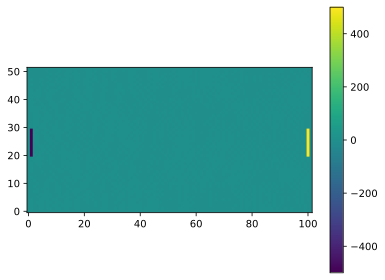

In [12]:
#compute divergence
divu = np.zeros_like(p)
for i in range(1, nx+1):
        for j in range(1, ny+1):
            divu[j,i] = (u[j,i+1] - u[j,i])/dx + (v[j+1,i] - v[j,i])/dy

plt.imshow(divu, origin ='lower')
plt.colorbar()
plt.show()

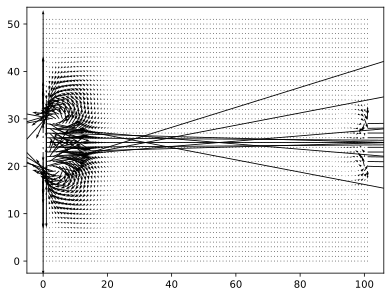

In [13]:
plt.quiver(u,v)
#plt.quiver(u_frames[:,:,50],v_frames[:,:,50])
plt.show()

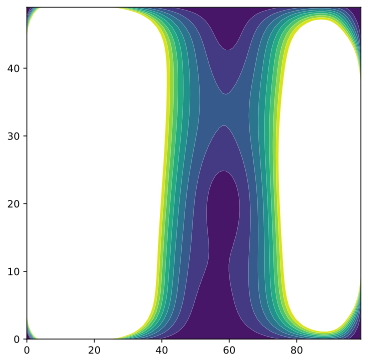

In [14]:
fig = plt.figure(figsize=[6,6],dpi=600)
u_center = np.float128(0.5*(u[1:-1,2:] + u[1:-1,1:-1]))
v_center = np.float128(0.5*(v[2:,1:-1] + v[1:-1,1:-1]))
speed = np.sqrt(u_center*u_center + v_center*v_center)

levels = np.linspace(speed.min(), 0.001, 10)
plt.contourf(speed, levels=levels)



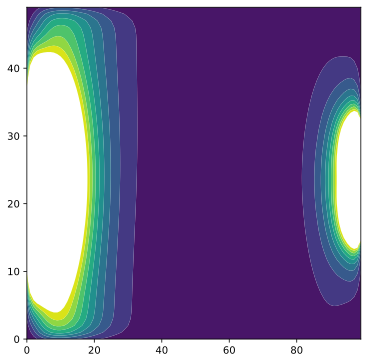

In [15]:
fig = plt.figure(figsize=[6,6],dpi=600)
myimages = []
for k in range(10):

    
    u_center = 0.5*(u_frames[1:-1,2:,k] + u_frames[1:-1,1:-1,k])
    v_center = 0.5*(v_frames[2:,1:-1,k] + v_frames[1:-1,1:-1,k])
    speed = np.sqrt(u_center*u_center + v_center*v_center)
    levels = np.linspace(speed.min(), 0.01, 10)
    img = plt.contourf(speed,levels=levels)

    
    
    myimages.append([img])


anim = animation.ArtistAnimation(fig=fig, artists=myimages, interval=500)
anim.save('myanimation.gif') 
plt.show()

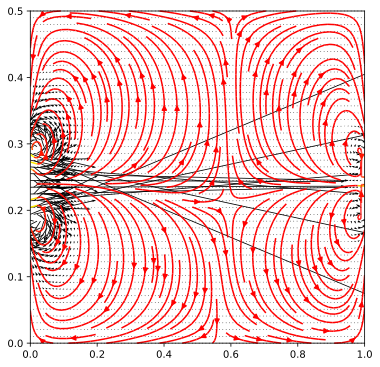

In [16]:
x_formesh = np.linspace(0,lx,nx)
y_formesh = np.linspace(0,ly,ny)
xx,yy = np.meshgrid(x_formesh,y_formesh)
nn = 1
fig = plt.figure(figsize=[6,6],dpi=600)
plt.quiver(xx[::nn,::nn],yy[::nn,::nn],u_center[::nn,::nn],v_center[::nn,::nn])
plt.xlim([xx[0,0],xx[0,-1]])
plt.ylim([yy[0,0],yy[-1,0]])
# ax.set_xlim([xx[0,0],xx[0,-1]])
plt.streamplot(xx,yy,np.float64(u_center), np.float64(v_center), color=np.sqrt(u_center*u_center + v_center*v_center),density=1.5,cmap=plt.cm.autumn,linewidth=1.5)

In [17]:
u_framescc = 0.5*(u_frames[1:-1,2:,:] + u_frames[1:-1,1:-1,:])
v_framescc = 0.5*(v_frames[2:,1:-1,:] + v_frames[1:-1,1:-1,:])


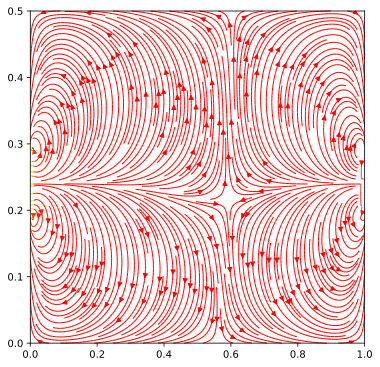

In [18]:

fig = plt.figure(figsize=[6,6],dpi=600)
plt.xlim([xx[0,0],xx[0,-1]])
plt.ylim([yy[0,0],yy[-1,0]])

def animate(i):
    fig.clear()
    plt.xlim([xx[0,0],xx[0,-1]])
    plt.ylim([yy[0,0],yy[-1,0]])

    return plt.streamplot(xx,yy,np.float64(u_framescc[:,:,i]), np.float64(v_framescc[:,:,i]), color=np.sqrt(u_center*u_center + v_center*v_center),density=3,cmap=plt.cm.autumn,linewidth=1.0)


anim = animation.FuncAnimation(fig,animate, frames= frames, interval= 400)
anim.save('myanimation4.mp4')

In [94]:
#function that takes in u_framescc, v_framescc, x0, y0 and outputs x_line and y_line which are the coordinates of the lines
#at increasing times.

def pathline(u_framescc,v_framescc, x0, y0, tau_ratio):
    x = x0
    y = y0

    x_line = []
    y_line = []
    for f in range(frames):

        for k in range(tau_ratio):
            
            #boundry conditions
            if x < 0.0:
                x = 0.01
            elif x > lx:
                x = lx - 0.01

            if y < 0.0:
                y = 0.01
            elif y > lx:
                x = ly - 0.01


            
            i = round(y/dy) #between 0-49
            j = round(x/dx) #between 0-99
            
            #print("i =", i)
            #print(x)
            #x_line.append(x)
            #y_line.append(y)

            #g = u_framescc[i, j, f]*(dt/tau_ratio)
            if 0.0 <= x <= lx :
                x_line.append(x)

                x += u_framescc[i, j, f]*(dt/tau_ratio)

            
            
            if 0 <= y <= ly :
                y_line.append(y)
                y += v_framescc[i, j, f]*(dt/tau_ratio)


    return x_line, y_line
        

linex0, liney0 = pathline(u_framescc, v_framescc, 0.7, 0.35, 1000) #x= 0.0-0.99, y=0.0-0.49


#line matrix produces a matrix such that the columns are coordinates for each line. 
xline_matrix = []
yline_matrix = []
for linenum in range(10):

    linexn, lineyn = pathline(u_framescc,v_framescc, 0.0, linenum/40, 500)

    xline_matrix.append(linexn)
    yline_matrix.append(lineyn)



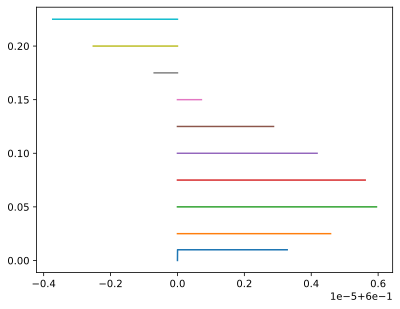

In [95]:
sizes = np.random.uniform(15, 80, len(linex0))
colors = np.random.uniform(15, 80, len(liney0))

# plot
fig, ax = plt.subplots()

#ax.scatter(linex0, liney0, s=sizes, c=colors, vmin=0, vmax=100)

for plots in range(10):
    ax.plot(xline_matrix[plots],yline_matrix[plots])